In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_train_HOTs_nonAuto as ncm
import src.bio_eqn_case.bio_eqn as bio
from src.bio_eqn_case.bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy.interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__) 

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_ncm_args(ncm.ncm_arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, 
                 decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 tau_max = 1.1, tau = 0.2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 365, nt = 365, nz = 50, z_max = -100, a = 0.07, g_max = 0.81e-5 * (60*60*24), k_P = 0.06, 
                 k_D = 0.01, k_W = 0.08, K_N = 0.5, K_P = 0.25, m_p = 9.26e-7 * (60*60*24), m_z = 6.94e-7 * (60*60*24), 
                 T_opt = 20, mu_max = 3.25e-5 * (60*60*24), alpha = 1.62e-6 * (60*60*24), beta = 3.24e-8 * (60*60*24), 
                 epsilon = 1.736e-7 * (60*60*24), lamb = 0.3, gamma = 0.4, C_P = 6.625, C_Z = 5.625, C_D = 7.5, 
                 gamma_c = 0.01, T_bio_min = 10, T_bio_max = 10, Temp = None, Salt = None, I_0 = 158.075, K_z0 = 8.64, 
                 K_zb = 0.0864, gamma_K = 0.1, bio_model_low_complex = 'NPZD-OA', 
                 bio_model_high_complex = 'NPZD-OA', isplot = True,
                 ode_alg_name = 'dopri5', nsteps = -1, is_tstart_zero = True, 
                 lambda_l1_mark = 0., lambda_l2_mark = 0., 
                 lambda_l1_non_mark = 0., lambda_l2_non_mark = 0., prune_thres = 0., mse_weight = 0., max_deriv = 2,
                 acc = 2, extra_terms_high_complex = 1, extra_terms_low_complex = 0, 
                 train_ens_size = 1, ens_to_plot = -1, skip_bnd = 0, Z_mort_sat = 1.): # add more arguments as needed

        ncm.ncm_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, 
                           tau_max = tau_max, tau = tau, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)

        self.args_train_lf = [bio.bio_eqn_args(T = T, nt = nt, nz = nz, z_max = z_max, a = a, g_max = g_max, k_P = k_P, 
                                  k_D = k_D, k_W = k_W, K_N = K_N, K_P = K_P, m_p = m_p, m_z = m_z, T_opt = T_opt, 
                                  mu_max = mu_max, alpha = alpha, beta = beta, epsilon = epsilon, lamb = lamb, 
                                  gamma = gamma, C_P = C_P, C_Z = C_Z, C_D = C_D, gamma_c = gamma_c, T_bio_min = T_bio_min, 
                                  T_bio_max = T_bio_max, bio_model = bio_model_low_complex, Temp = Temp, Salt = Salt, I_0 = I_0, 
                                  K_z0 = K_z0, K_zb = K_zb, gamma_K = gamma_K, extra_terms = extra_terms_low_complex,
                                  acc = acc, max_deriv = max_deriv, skip_bnd = skip_bnd, Z_mort_sat = Z_mort_sat)]
        
        self.args_train_hf = [bio.bio_eqn_args(T = T, nt = nt, nz = nz, z_max = z_max, a = a, g_max = g_max, k_P = k_P, 
                                  k_D = k_D, k_W = k_W, K_N = K_N, K_P = K_P, m_p = m_p, m_z = m_z, T_opt = T_opt, 
                                  mu_max = mu_max, alpha = alpha, beta = beta, epsilon = epsilon, lamb = lamb, 
                                  gamma = gamma, C_P = C_P, C_Z = C_Z, C_D = C_D, gamma_c = gamma_c, T_bio_min = T_bio_min, 
                                  T_bio_max = T_bio_max, bio_model = bio_model_high_complex, Temp = Temp, Salt = Salt, I_0 = I_0, 
                                  K_z0 = K_z0, K_zb = K_zb, gamma_K = gamma_K, extra_terms = extra_terms_high_complex,
                                  acc = acc, max_deriv = max_deriv, skip_bnd = skip_bnd, Z_mort_sat = Z_mort_sat)]
        
        self.train_ens_size = train_ens_size
        
        self.args_eval_hf = self.args_train_hf[ens_to_plot]
        self.args_eval_lf = self.args_train_lf[ens_to_plot]
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps
        
        self.lambda_l1_mark = lambda_l1_mark
        self.lambda_l2_mark = lambda_l2_mark
        self.lambda_l1_non_mark = lambda_l1_non_mark
        self.lambda_l2_non_mark = lambda_l2_non_mark
        self.prune_thres = prune_thres
        self.mse_weight = mse_weight

In [5]:
class sigmoid_func:
    def __init__(self, T_top, T_bot, z_max):
        self.T_top = T_top
        self.T_bot = T_bot
        self.z_max = z_max
        
    def __call__(self, z, t):
        A = self.T_top
        K = self.T_bot
        C = 1
        Q = 0.5
        B = 0.25
        nu = 2.0
        T = lambda x: A + ((K - A) / (C + Q * np.exp(-B*x))**(1./nu))
        
        T = np.stack([ T(np.abs(z) + self.z_max/2) for i in range(t.shape[0])], axis=0)
        
        return T

### Define the neural net architecture

In [6]:
class OA_constraint(tf.keras.constraints.Constraint):
    
    def __init__(self, app):
        self.app = app

    def __call__(self, w):
        
        w = tf.concat([-(w[:, 1:2] + w[:, 2:3]), w[:, 1:2], w[:, 2:3]], axis=-1)
        
        w = tf.concat([w, - self.app.C_P * w[:, 1:2] - self.app.C_Z * w[:, 2:3], -w[:, 0:1] / self.app.water_density], axis=-1)
        
        return w

In [7]:
class NPZ_constraint(tf.keras.constraints.Constraint):
    
    def __init__(self, app):
        self.app = app

    def __call__(self, w):
        
        w = tf.concat([-(w[:, 1:2] + w[:, 2:3]), w[:, 1:4], w[:, 4:] / self.app.water_density], axis=-1)
        
#         w = tf.concat([w, -self.app.C_P * w[:, 1:2] - self.app.C_Z * w[:, 2:3], -w[:, 0:1] / self.app.water_density], axis=-1)
        
        return w

In [8]:
class TruncatedNormal_with_OA_constraint(tf.keras.initializers.Initializer):

    def __init__(self, stddev, weight_constraint):

        self.stddev = stddev
        self.weight_constraint = weight_constraint

    def __call__(self, shape, dtype=None, **kwargs):
        
        w = tf.random.truncated_normal(shape, stddev=self.stddev)
        
        return self.weight_constraint(w)

In [9]:
class NNFunc_mark(tf.keras.Model):

    def __init__(self, weight_constraint, **kwargs):
        super(NNFunc_mark, self).__init__(**kwargs)
        
        self.out = tf.keras.layers.Dense(5, activation='linear',
                                       kernel_initializer=TruncatedNormal_with_OA_constraint(stddev=0.00001, weight_constraint = weight_constraint), use_bias=False,
                                        kernel_constraint = weight_constraint)
        
    def process_input(self, y, shp):     
               
        y = tf.reshape(y, shp)
        
        return y
    
    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z, extra_channel = None):
        
        z = z[:, :, 0]
        
        z_shp = tf.shape(z)
        z = tf.transpose(tf.reshape(z, [z_shp[0], 5, -1]), perm = [0, 2, 1])
        
        z_shp = tf.shape(z)
        
        z = self.process_input(z, [-1, 5])
        
        z = tf.cast(z, tf.float64)
        
        z_itself = tf.einsum('ab, ab -> ab', z, z)
        
        z_lim = tf.einsum('ab, ab -> ab', z_itself, 1. / (1. + z))
        
        z_exp = tf.exp(z)
        
        z = tf.cast(tf.concat([z[:, 2:3], z_itself[:, 2:3], z_lim[:, 2:3], z_exp[:, 2:3]], axis=-1), tf.float32)
        
        z = self.pass_layers(tf.cast(z, tf.float32))
        
#         z = tf.concat([-z, tf.zeros([z.shape[0], 1]), z, -5.625 * z, z / 1028.13], axis=1)
        
        z = self.process_input(z, z_shp)
        
        z = tf.reshape(tf.transpose(z, perm = [0, 2, 1]), [z_shp[0], -1])
        return z

In [10]:
class NNFunc(tf.keras.Model):

    def __init__(self, weight_constraint, **kwargs):
        super(NNFunc, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(5, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=False)
        
#         self.x2 = tf.keras.layers.Dense(5, activation='swish',
#                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=False)

        self.x3 = tf.keras.layers.Dense(5, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=False)
        
        self.out = tf.keras.layers.Dense(4, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.00001), use_bias=False)
        
        self.norm = tf.convert_to_tensor([[1., 1., 1., 1.]])
    
    def process_input(self, y, shp):     
               
        y = tf.reshape(y, shp)
        
        return y
    
    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z, extra_channel = None):
        
        z = z[:, :, 0]
        
        z_shp = tf.shape(z)
        z = tf.transpose(tf.reshape(z, [z_shp[0], 5, -1]), perm = [0, 2, 1])
        
        z_shp = tf.shape(z)
        
        z = tf.concat([z, extra_channel[0]], axis=-1)
        
        z = self.process_input(z, [-1, 6])
        
        z = tf.cast(z, tf.float64)
        
        z = tf.concat([z[:, 0:3], z[:, -1:]], axis=-1)
        
        norm = tf.tile(1/self.norm, [z.shape[0], 1])
        
        z = tf.einsum('ab, ab -> ab', tf.cast(z, tf.float64), tf.cast(norm, tf.float64))
        
        z = self.pass_layers(tf.cast(z, tf.float32))
        
        z = tf.concat([-(z[:, 0:1] + z[:, 1:2]), z[:, 0:3], z[:, 3:] / 1028.13], axis=-1)
        
        z = self.process_input(z, z_shp)
        
        z = tf.reshape(tf.transpose(z, perm = [0, 2, 1]), [z_shp[0], -1])
        return z

In [11]:
class split_zy:
    def __init__(self, zy, args):
        self.zy = zy
        self.args = args

    def get_z(self, t):
        return self.zy(t)[:, :self.args.state_dim]
    
    def get_y(self, t):
        return self.zy(t)[:, self.args.state_dim:]

In [12]:
class DistDDEFunc(tf.keras.Model):

    def __init__(self, mark_nn_part, non_mark_nn_part, rom_model, app, norm_const, **kwargs):
        super(DistDDEFunc, self).__init__(**kwargs)
        self.mark_nn_part = mark_nn_part
        self.non_mark_nn_part = non_mark_nn_part
        self.rom_model = rom_model
        self.args = app
        
        self.norm_const = norm_const
        
    def overwrite_rom(self, app, rom_model, norm_const):
        self.rom_model = rom_model
        self.args = app
        self.norm_const = norm_const
    
    def extra_channels(self, t):
        
        if np.isscalar(t): t = np.array([t])
        channel_to_add = [tf.expand_dims(tf.convert_to_tensor(self.rom_model.PAR(t, self.args.I_0_t)), axis=-1)]
        
        return channel_to_add
    
    def process_input(self, zy, t ,tau, flag_fwd=0):     
        
        input = [self.compute_derivatives(zy(t)[:, :self.args.state_dim], flag_fwd)]
        input.append(self.compute_derivatives(zy(t - tau)[:, :self.args.state_dim], flag_fwd))
        
        return input
    
    def call_non_mark_nn_part(self, input, extra_channels_t, extra_channels_t_minus_tau):
        
        gz_t1 = self.non_mark_nn_part(input[0], extra_channels_t)
        gz_t2 = self.non_mark_nn_part(input[1], extra_channels_t_minus_tau)
        dy_dt = gz_t1 - gz_t2
        
        return dy_dt
    
    def call_nn_part_indiv(self, z, extra_channels_t, flag_mark = 0, flag_fwd = 0):
        
        z = self.compute_derivatives(z, flag_fwd)
        
        if flag_mark == 0:
            return self.non_mark_nn_part(z, extra_channels_t)
        else:
            return self.mark_nn_part(z)
    
    def compute_derivatives(self, u, flag_fwd = 0):
        
        u_stack = [u]
        
        for i in range(1, self.args.max_deriv+1):
            u_stack.append(np.einsum('ab, cb -> ca', self.rom_model.full_vander[i], u.numpy()))
        
        u_stack = tf.convert_to_tensor(np.stack(u_stack, axis=-1))
        
        return u_stack

    def __call__(self, uy, t ,tau, t_start = np.array([0.])):
        
        get_y = split_zy(uy, self.args).get_y(t).numpy()
        
        input = self.process_input(uy, t ,tau)
        dy_dt = self.call_non_mark_nn_part(input, self.extra_channels(t + t_start), self.extra_channels(t + t_start - tau)) # y does include boundaries
        
        u_t = input[0][:, :, 0]
        
        du_dt = self.rom_model.rhs(uy(t)[:, :self.args.state_dim].numpy(), t, t_start)
        
        du_dt = du_dt + self.call_nn_part_indiv(u_t, self.extra_channels(t + t_start), flag_mark = 1).numpy() + get_y
        
        if self.args.skip_bnd != 1:
            du_dt = self.rom_model.apply_bnd(t+t_start, u_t, du_dt)
        
        du_dt = tf.convert_to_tensor(du_dt, dtype=tf.float32)
        
        duy_dt = tf.concat([du_dt, dy_dt], axis=-1)
        
        return duy_dt

### Initialize model related parameters

In [23]:
args = bio_eq_ncm_args(batch_time = 3*1, batch_time_skip = 1, batch_size = 8, epochs = 200, learning_rate = 0.075, 
                 decay_rate = 0.97, test_freq = 25, plot_freq = 25, tau_max = 5., tau = 2.5,
                 model_dir = 'NPZOA_nDistDDE_testcase/model_dir_case11df', restart = 0, val_percentage = 11.,
                 T = 30, nt = int(300), nz = 20, z_max = -100, a = 0.07, g_max = 0.81e-5 * (60*60*24), k_P = 0.06, 
                 k_D = 0.01, k_W = 0.08, K_N = 0.5, K_P = 0.25, m_p = 9.26e-7 * (60*60*24), m_z = 6.94e-7 * (60*60*24) / 2, 
                 T_opt = 20, mu_max = 3.25e-5 * (60*60*24), alpha = 1.62e-6 * (60*60*24), beta = 3.24e-8 * (60*60*24), 
                 epsilon = 1.736e-7 * (60*60*24), lamb = 0.3, gamma = 0.4, C_P = 6.625, C_Z = 5.625, C_D = 7.5, 
                 gamma_c = 0.01, T_bio_min = 10, T_bio_max = 20, Temp = sigmoid_func(20, 20, -100), 
                 Salt = sigmoid_func(31.4, 32.8, -100), I_0 = 158.075, K_z0 = 8.64, 
                 K_zb = 0.0864, gamma_K = 0.1, bio_model_low_complex = 'NPZ-OA', 
                 bio_model_high_complex = 'NPZD-OA', isplot = True, ode_alg_name = 'dopri5', nsteps = 20, 
                 is_tstart_zero = False, lambda_l1_mark = 3 * 5e-4, lambda_l2_mark = 1e-3, lambda_l2_non_mark = 1e-5,
                 prune_thres = 5e-3, mse_weight = 0., max_deriv = 2,
                 acc = 2, extra_terms_high_complex = 1, skip_bnd = 0)

### Make a copy of the current script

In [24]:
testcase_dir = 'generalized_nCMs/testcases/bio_eqn'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir, save_user_inputs=False)

### Run setup

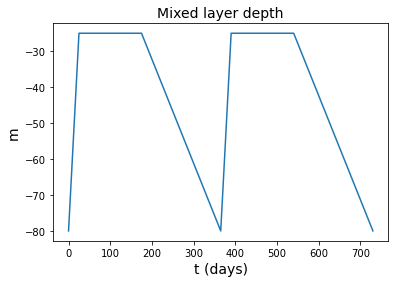

/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Higher complexity model done!


In [25]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup_npzoa

## Main part starts here

### Make objects and define learning-rate schedule

In [26]:
time_meter = ncm.RunningAverageMeter(0.97)

grid_obj = fdgen.grid(args.args_eval_lf, args.args_eval_lf.z)
deriv_obj = fdgen.deriv(args.args_eval_lf, grid_obj)

eval_rom_rhs_obj = bio.bio_eqn(args.args_eval_lf, K_z_obj, grid_obj, deriv_obj)
func = DistDDEFunc(NNFunc_mark(OA_constraint(args.args_eval_lf)), NNFunc(NPZ_constraint(args.args_eval_lf)), eval_rom_rhs_obj, args.args_eval_lf, None)

plot_obj = custom_plot_npzoa(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), tf.concat([x_low_complex, val_x_low_complex], axis=0), 
                       args.args_eval_lf.z, tf.concat([t, val_t], axis=0), save_dir_obj.figsave_dir, args.args_eval_lf, args.restart)


### Quick test to see how the true coefficients looks like

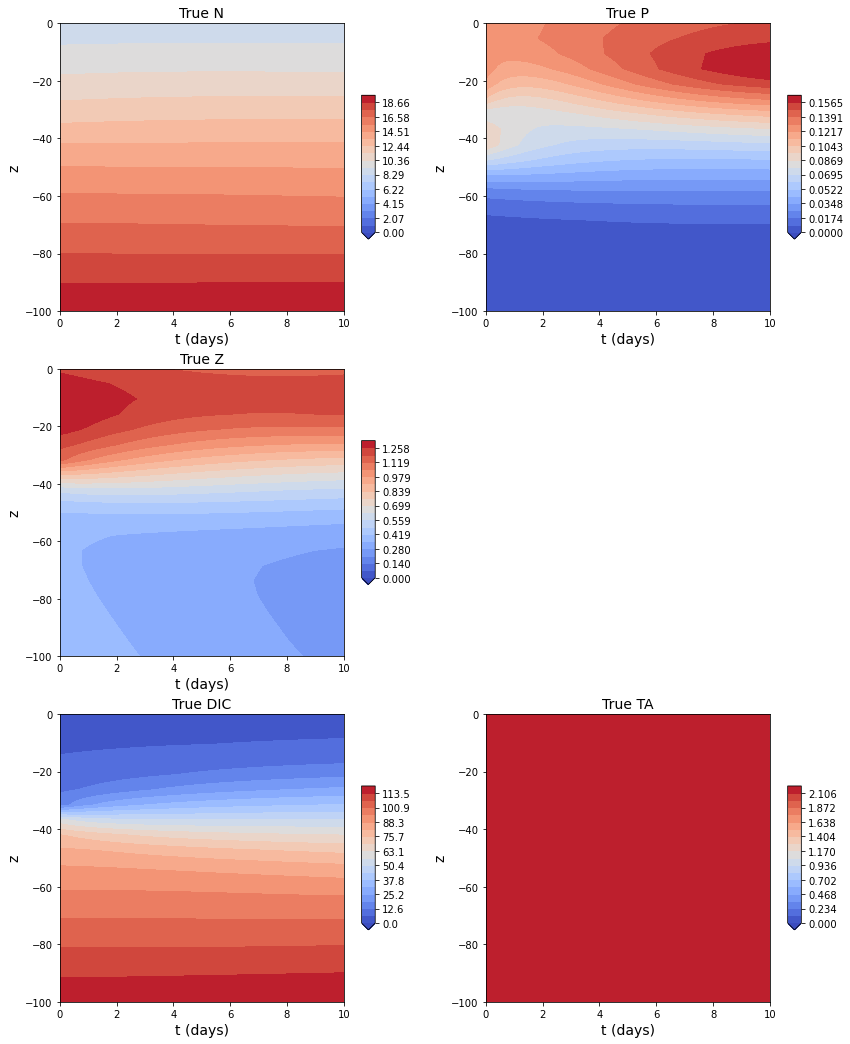

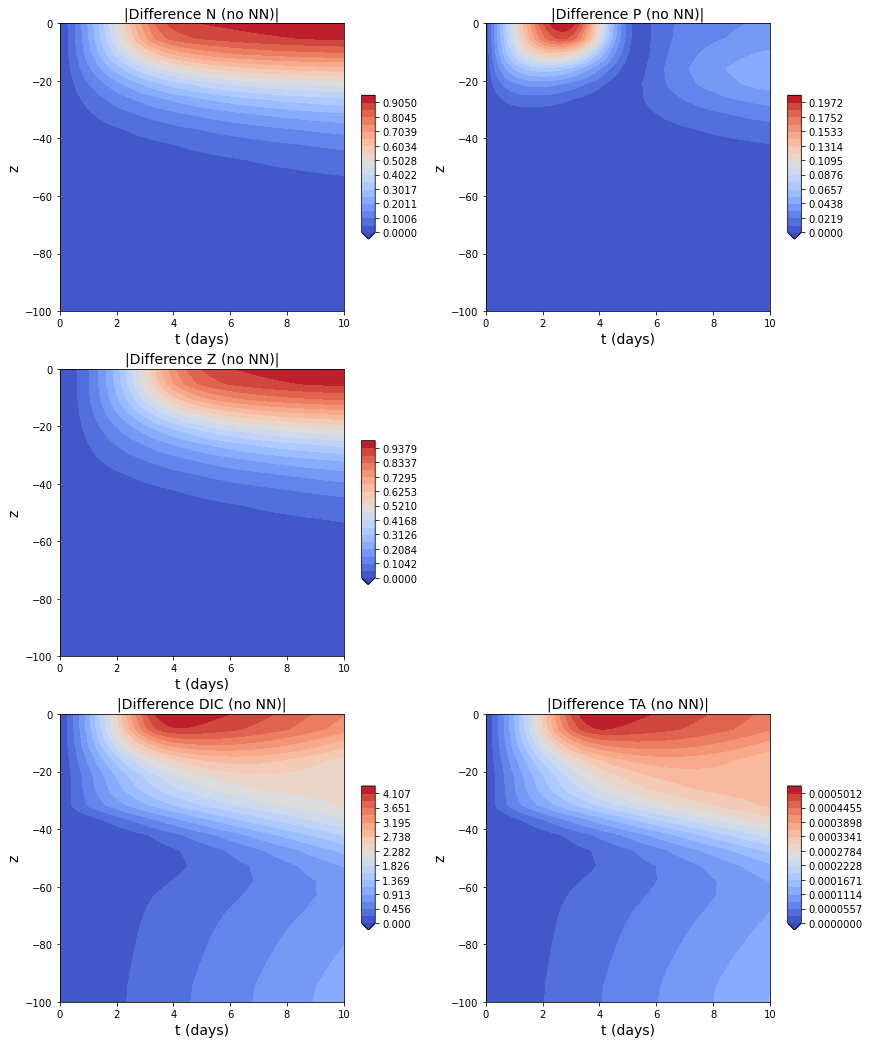

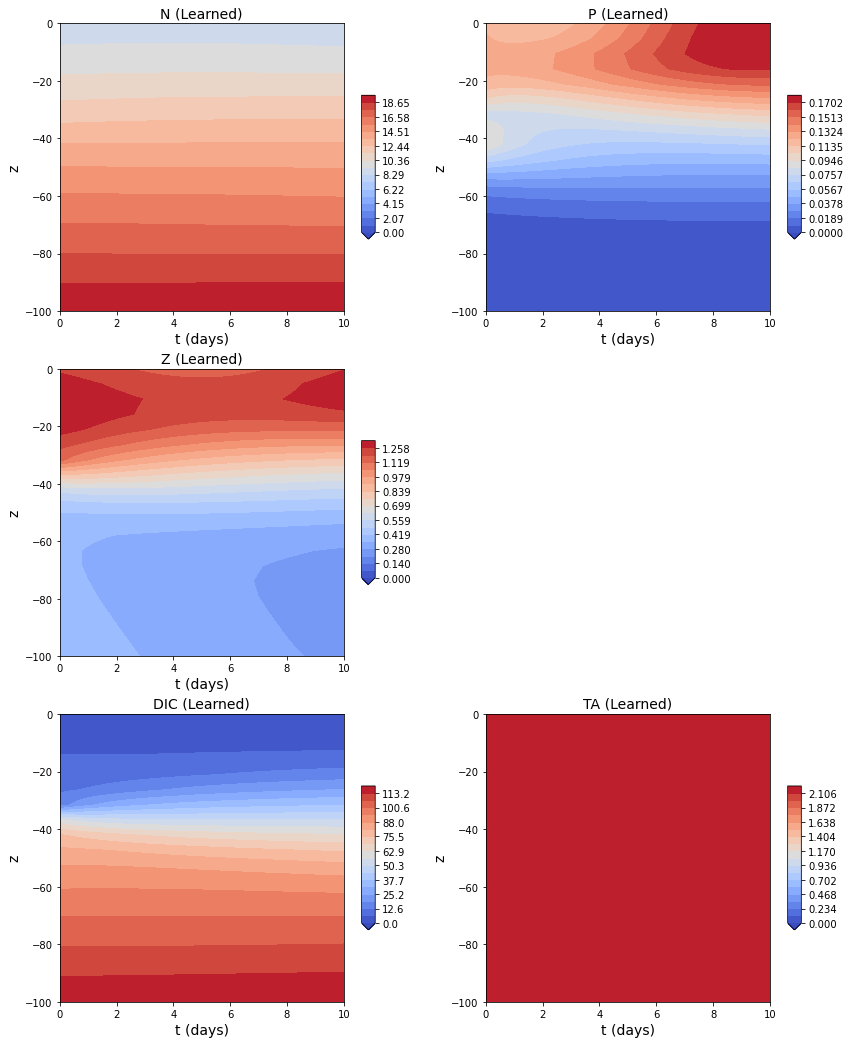

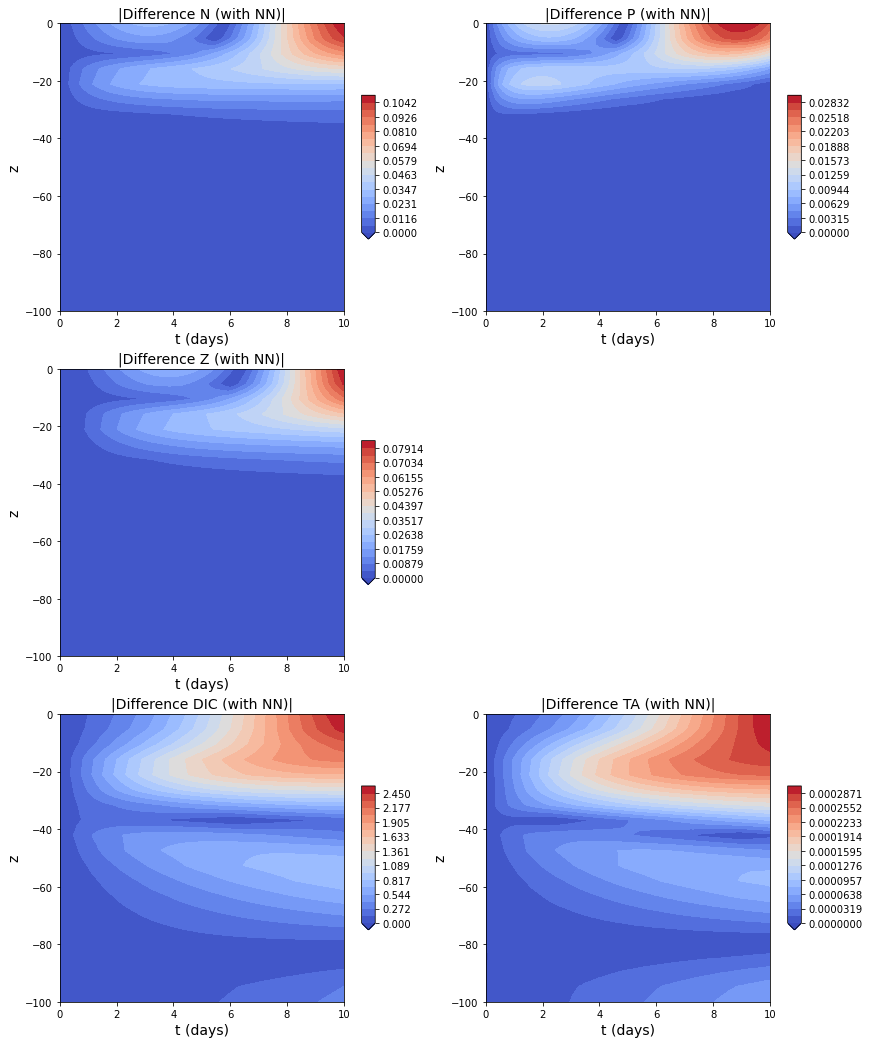

In [27]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
process_true_z0 = ncm.process_DistDDE_IC(true_x0_low_complex, func.call_nn_part_indiv, func.extra_channels, t_lowerlim = t[0] - args.tau, t_upperlim = t[0])
pred_y = ddeinttf(func, process_true_z0, tf.concat([t, val_t], axis=0), fargs=(args.tau,), alg_name = args.ode_alg_name, nsteps = args.nsteps)
    
plot_obj.plot(pred_y, epoch = 0)


In [29]:
func.non_mark_nn_part.summary()

Model: "nn_func_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  20        
_________________________________________________________________
dense_6 (Dense)              multiple                  25        
_________________________________________________________________
dense_7 (Dense)              multiple                  20        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [30]:
func.mark_nn_part.summary()

Model: "nn_func_mark_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


### Training starts here

In [18]:
class custom_plot:

    def __init__(self, z, t, args, K_obj = None):
        self.t = t
        self.args = args
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        self.K_obj = K_obj
        
    def plot(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None, str_fmt = '%.2f'):
        
        fig = plt.figure(figsize=(10, 47), facecolor='white')
        ax_N = fig.add_subplot(511)
        ax_P = fig.add_subplot(512)
        ax_Z = fig.add_subplot(513)
        ax_DIC = fig.add_subplot(514)
        ax_TA = fig.add_subplot(515)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        B_DIC = tf.transpose(tf.squeeze(pred_y[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy()
        B_TA = tf.transpose(tf.squeeze(pred_y[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [[np.min(B_N.flatten()), np.max(B_N.flatten())]]
            max_cbar.append([np.min(B_P.flatten()), np.max(B_P.flatten())])
            max_cbar.append([np.min(B_Z.flatten()), np.max(B_Z.flatten())])
            max_cbar.append([np.min(B_DIC.flatten()), np.max(B_DIC.flatten())])
            max_cbar.append([np.min(B_TA.flatten()), np.max(B_TA.flatten())])
        
        self.plot_indiv(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap, t_max)
        self.plot_indiv(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap, t_max)
        self.plot_indiv(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap, t_max)
        self.plot_indiv(ax_DIC, title_start + ' DIC ' + title_end, B_DIC, max_cbar[3], cmap, t_max)
        self.plot_indiv(ax_TA, title_start + ' TA ' + title_end, B_TA, max_cbar[4], cmap, t_max, str_fmt = str_fmt)

        plt.show()
        
    def plot_with_mld(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None):
        
        fig = plt.figure(figsize=(10, 47), facecolor='white')
        ax_N = fig.add_subplot(511)
        ax_P = fig.add_subplot(512)
        ax_Z = fig.add_subplot(513)
        ax_DIC = fig.add_subplot(514)
        ax_TA = fig.add_subplot(515)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        B_DIC = tf.transpose(tf.squeeze(pred_y[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy()
        B_TA = tf.transpose(tf.squeeze(pred_y[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [[np.min(B_N.flatten()), np.max(B_N.flatten())]]
            max_cbar.append([np.min(B_P.flatten()), np.max(B_P.flatten())])
            max_cbar.append([np.min(B_Z.flatten()), np.max(B_Z.flatten())])
            max_cbar.append([np.min(B_DIC.flatten()), np.max(B_DIC.flatten())])
            max_cbar.append([np.min(B_TA.flatten()), np.max(B_TA.flatten())])
        
        self.plot_indiv_with_mld(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap, t_max)
        self.plot_indiv_with_mld(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap, t_max)
        self.plot_indiv_with_mld(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap, t_max)
        self.plot_indiv_with_mld(ax_DIC, title_start + ' DIC ' + title_end, B_DIC, max_cbar[3], cmap, t_max)
        self.plot_indiv_with_mld(ax_TA, title_start + ' TA ' + title_end, B_TA, max_cbar[4], cmap, t_max)

        plt.show()

        
    def plot_indiv(self, ax, title, B, max_cbar_lim, cmap, t_max=None, str_fmt = '%.2f'):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 40), extend='both')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10, format=str_fmt, spacing='proportional', ticks=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 5))
        cbar.ax.tick_params(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        
    def plot_indiv_with_mld(self, ax, title, B, max_cbar_lim, cmap, t_max=None, str_fmt = '%.2f'):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 40), extend='both')
        
        
        ax.plot(self.t, self.K_obj.M_intrp(self.t), linewidth=3, color='r', linestyle='--')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10, format=str_fmt, spacing='proportional', ticks=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 5))
        cbar.ax.tick_params(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        
    def plot_solar_intensity(self, t_max=None):
        fig = plt.figure(figsize=(4.2, 1), facecolor='white')
        ax = fig.add_subplot(111)
        
        f = ax.plot(self.t, self.args.I_0_t(self.t), linewidth=2, color='k')
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        ax.set_title('Solar Radiation', fontsize=12)
        ax.set_ylabel('$I_0$ (W $m^{-2}$)', fontsize=12)
        ax.set_xlabel('t (days)', fontsize=12)
        plt.xticks([*range(0, 400, 100)], fontsize = 11)
        plt.yticks(fontsize = 11)
        

In [19]:
custom_plot_obj = custom_plot(args.args_eval_lf.z, tf.concat([t, val_t], axis=0), args.args_eval_lf, K_z_obj)

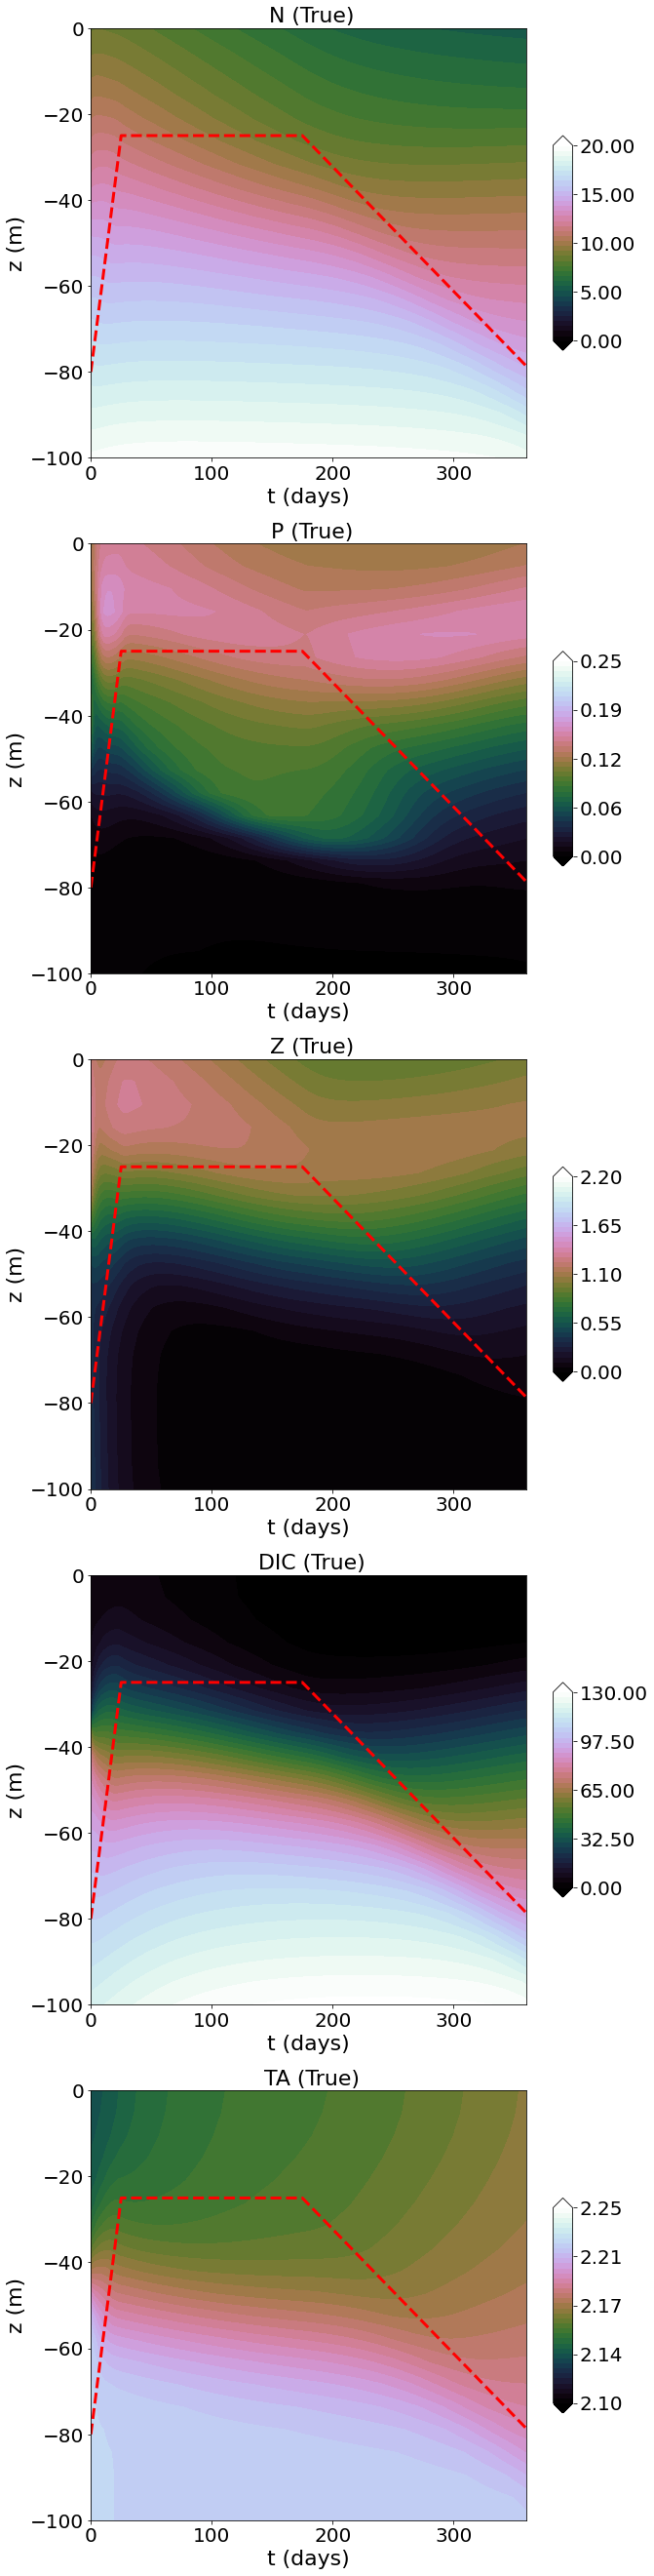

In [20]:
custom_plot_obj.plot_with_mld(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), '', '(True)', max_cbar = [[0, 20.], [0, .25], [0, 2.2], [0, 130.], [2.1, 2.25]], cmap = cm.cubehelix)

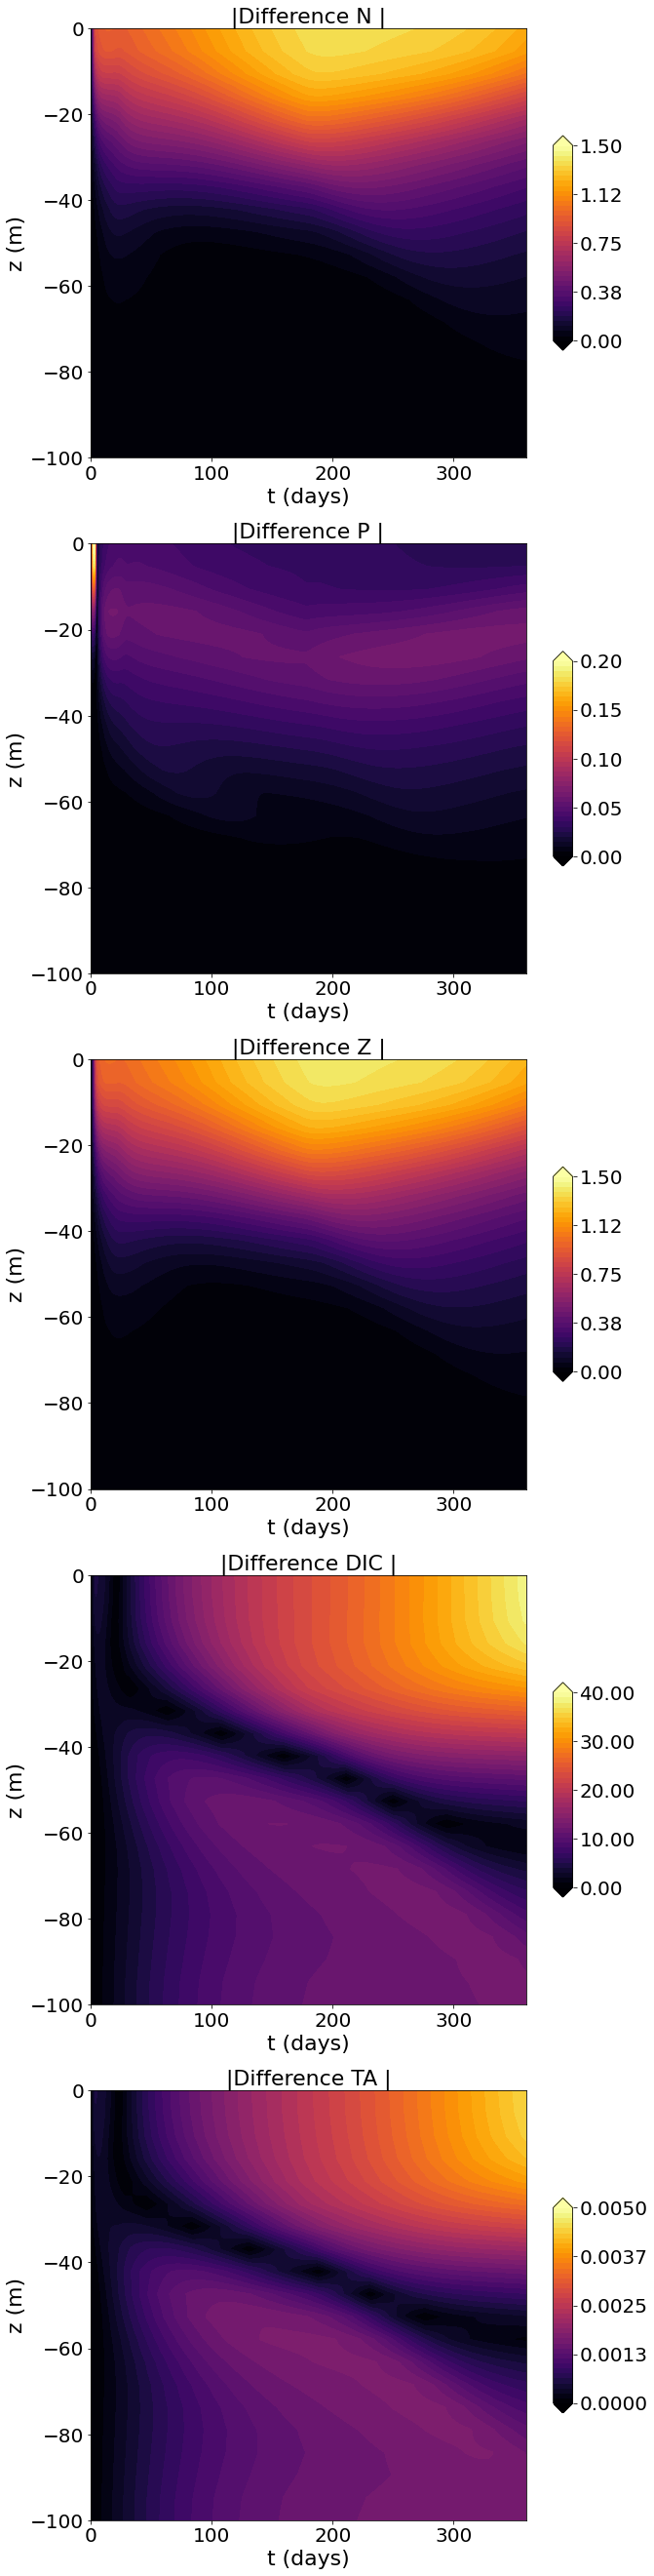

In [21]:
custom_plot_obj.plot(tf.abs(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0) - tf.concat([x_low_complex, val_x_low_complex], axis=0)), '|Difference', '|', max_cbar = [[0, 1.5], [0, 0.2], [0, 1.5], [0, 40.], [0, .005]], cmap=cm.inferno, str_fmt = '%.4f')

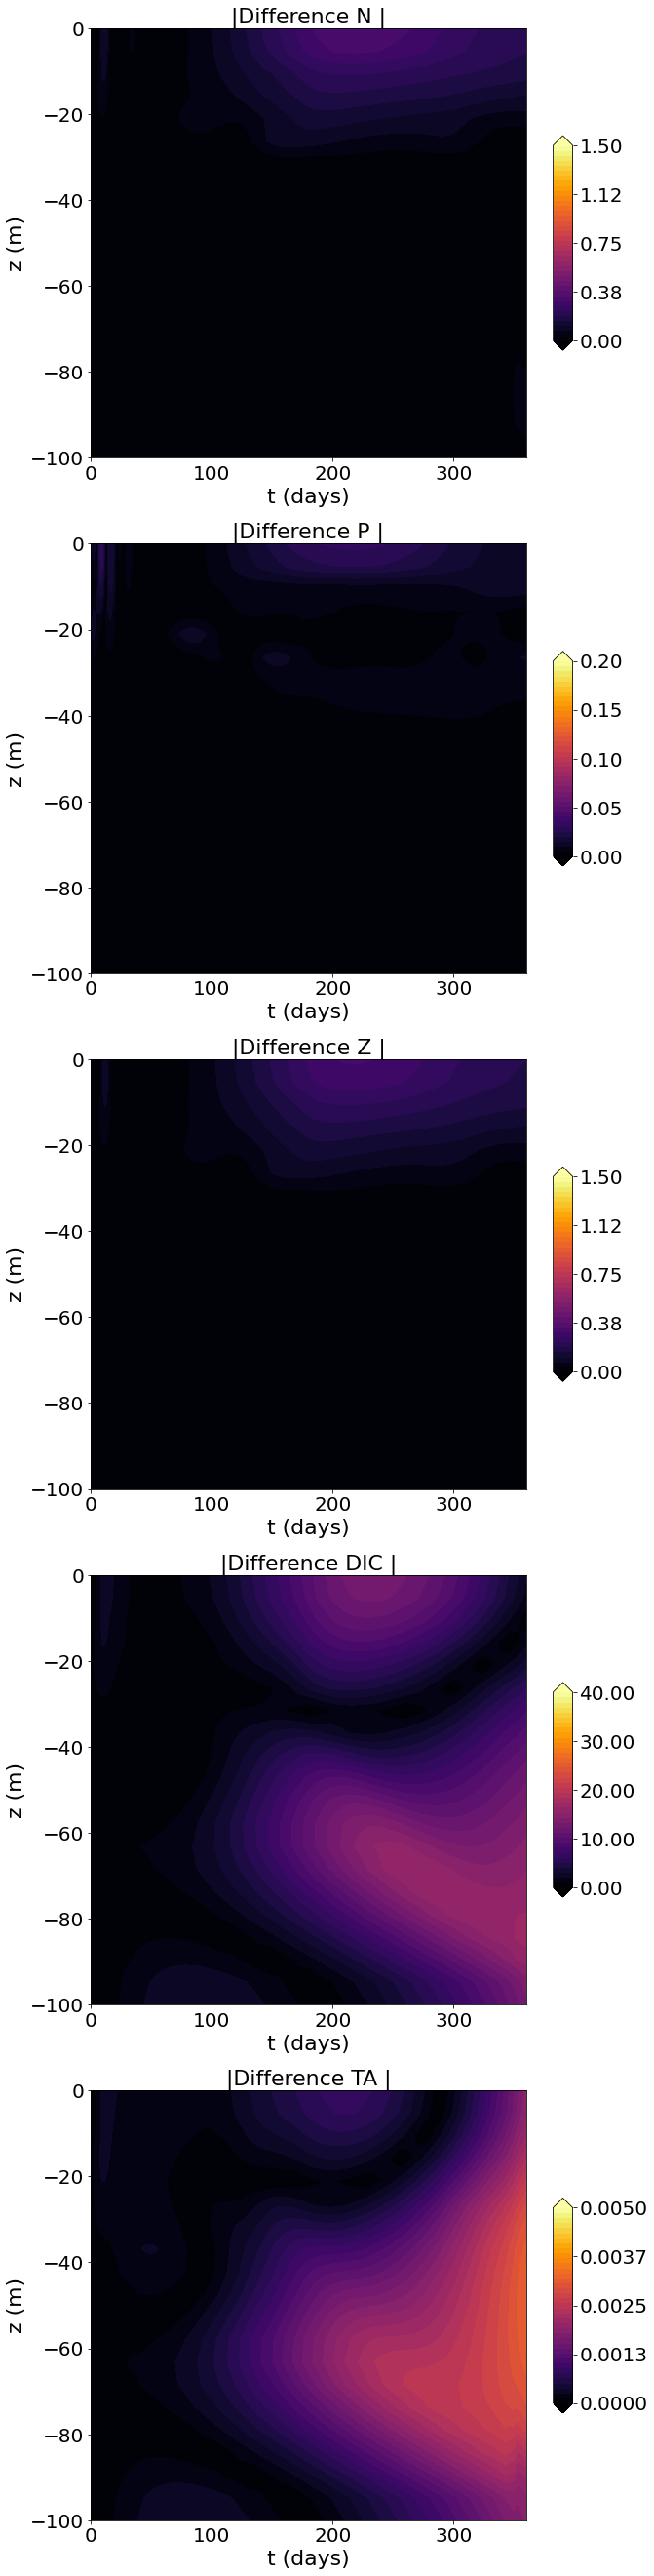

In [22]:
custom_plot_obj.plot(tf.abs(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0) - pred_y[:, :, 0:100]), '|Difference', '|', max_cbar = [[0, 1.5], [0, 0.2], [0, 1.5], [0, 40.], [0, .005]], cmap=cm.inferno, str_fmt = '%.4f')

In [23]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*self.thres
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)
        
        error = np.mean(np.array(error))
        return error

In [24]:
truth_all = tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0)
low_fid = tf.concat([x_low_complex, val_x_low_complex], axis=0)

In [25]:
truth = truth_all[:, :, 0:args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error N: ', np.round(err_obj.l2_error(low_fid[:, :, 0:args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) N: ', np.round(err_obj.RMSE(low_fid[:, :, 0:args.args_eval_lf.nz]), 3))

print('L2 error N: ', np.round(err_obj.l2_error(pred_y[:, :, 0:args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) N: ', np.round(err_obj.RMSE(pred_y[:, :, 0:args.args_eval_lf.nz]), 3))

L2 error N:  [0.575]
RMSE error (>2%) N:  0.956
L2 error N:  [0.075]
RMSE error (>2%) N:  nan


/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
truth = truth_all[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error P: ', np.round(err_obj.l2_error(low_fid[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) P: ', np.round(err_obj.RMSE(low_fid[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]), 3))

print('L2 error P: ', np.round(err_obj.l2_error(pred_y[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) P: ', np.round(err_obj.RMSE(pred_y[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]), 3))

L2 error P:  [0.032]
RMSE error (>2%) P:  0.039
L2 error P:  [0.006]
RMSE error (>2%) P:  0.012


In [27]:
truth = truth_all[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error Z: ', np.round(err_obj.l2_error(low_fid[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) Z: ', np.round(err_obj.RMSE(low_fid[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]), 3))

print('L2 error Z: ', np.round(err_obj.l2_error(pred_y[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) Z: ', np.round(err_obj.RMSE(pred_y[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]), 3))

L2 error Z:  [0.602]
RMSE error (>2%) Z:  0.757
L2 error Z:  [0.07]
RMSE error (>2%) Z:  0.151


In [28]:
truth = truth_all[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error DIC: ', np.round(err_obj.l2_error(low_fid[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) DIC: ', np.round(err_obj.RMSE(low_fid[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]), 3))

print('L2 error DIC: ', np.round(err_obj.l2_error(pred_y[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) DIC: ', np.round(err_obj.RMSE(pred_y[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]), 3))

L2 error DIC:  [14.277]
RMSE error (>2%) DIC:  14.898
L2 error DIC:  [6.083]
RMSE error (>2%) DIC:  7.911


In [29]:
truth = truth_all[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error TA: ', np.round(err_obj.l2_error(low_fid[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]), 5))

print('RMSE error (>2%) TA: ', np.round(err_obj.RMSE(low_fid[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]), 3))

print('L2 error TA: ', np.round(err_obj.l2_error(pred_y[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]), 5))

print('RMSE error (>2%) TA: ', np.round(err_obj.RMSE(pred_y[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]), 3))

L2 error TA:  [0.00164]
RMSE error (>2%) TA:  nan
L2 error TA:  [0.001]
RMSE error (>2%) TA:  nan


In [30]:
os.chdir(basedir)

data_dict = {'true_x_low_complex':true_x_low_complex, 'val_true_x_low_complex':val_true_x_low_complex,
             'x_low_complex':x_low_complex, 'val_x_low_complex':val_x_low_complex, 'pred_y': pred_y, 't': t, 'val_t': val_t, 
            'z': args.args_eval_lf.z}

with open(os.path.join('generalized_nCMs/final_paper_scripts/Experiments2b', 'NPZOA_nDistDDE_testcase_C11df.pkl'), 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)